In [1]:
# Install libraries
!pip install -q datasets transformers sentence_transformers faiss-gpu seaborn matplotlib

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
from datasets import Dataset
import pandas as pd

# Read the CSV file
df = pd.read_csv('spa_guc_dataset.csv', delimiter='|')

# Create a new column with the desired format
df['text'] = '<s>[INST] ' + 'Traduce de Español a Wayuu' + ': ' + df['spa'] + ' [/INST] ' + df['guc'] + ' </s>'

# Drop the original columns
df = df.drop(['spa', 'guc'], axis=1)

dataset = Dataset.from_pandas(df)
dataset

Dataset({
    features: ['text'],
    num_rows: 119808
})

In [5]:
df.head()

,text
0,<s>[INST] Traduce de Español a Wayuu: ve [/INS...
1,<s>[INST] Traduce de Español a Wayuu: vete [/I...
2,<s>[INST] Traduce de Español a Wayuu: vaya [/I...
3,<s>[INST] Traduce de Español a Wayuu: vayase [...
4,<s>[INST] Traduce de Español a Wayuu: hola [/I...


Review Distribution of Data Tokens count

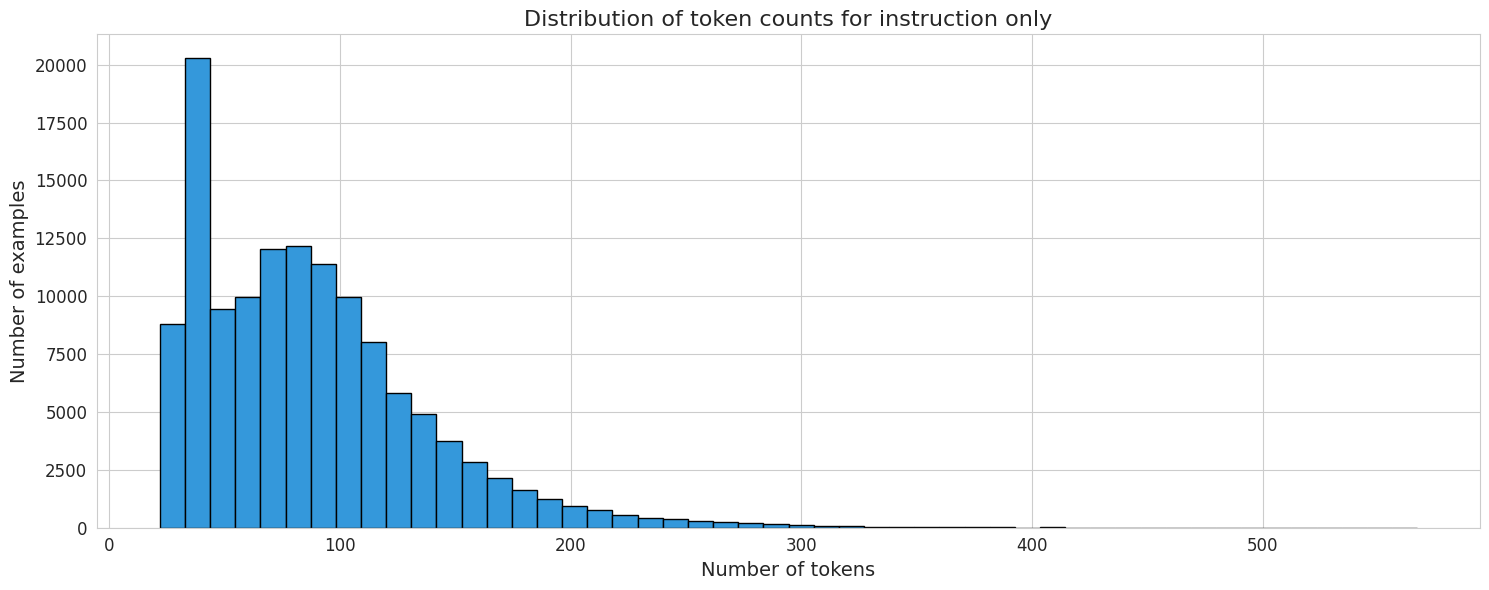

In [6]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-chat-hf")

# 2. Tokenize each row and count the number of tokens
instruction_token_counts = [len(tokenizer.tokenize(example["text"])) for example in dataset]

# Helper function to plot the distributions
def plot_distribution(token_counts, title):
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 6))
    plt.hist(token_counts, bins=50, color='#3498db', edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel("Number of tokens", fontsize=14)
    plt.ylabel("Number of examples", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot the distribution of token counts
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")

Use similarity seach to remove similiar sentences

In [8]:
from sentence_transformers import SentenceTransformer
import faiss
from datasets import Dataset, DatasetDict
from tqdm.autonotebook import tqdm
import numpy as np

def deduplicate_dataset(dataset: Dataset, model: str, threshold: float):
    sentence_model = SentenceTransformer(model)
    outputs = [example["text"] for example in dataset]

    print("Converting text to embeddings...")
    embeddings = sentence_model.encode(outputs, show_progress_bar=True)
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)
    normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    index.add(normalized_embeddings)

    print("Filtering out near-duplicates...")
    D, I = index.search(normalized_embeddings, k=2)
    to_keep = []

    for i in tqdm(range(len(embeddings)), desc="Filtering"):
        # If the second closest vector (D[i, 1]) has cosine similarity above the threshold
        if D[i, 1] >= threshold:
            # Check if either the current item or its nearest neighbor is already in the to_keep list
            nearest_neighbor = I[i, 1]
            if i not in to_keep and nearest_neighbor not in to_keep:
                # If not, add the current item to the list
                to_keep.append(i)
        else:
            # If the similarity is below the threshold, always keep the current item
            to_keep.append(i)

    dataset = dataset.select(to_keep)
    return DatasetDict({"train": dataset})

deduped_dataset = deduplicate_dataset(dataset, "thenlper/gte-large", 0.95)

Converting text to embeddings...


Batches: 100%|█████████████████████████████████████████████████████████████████████████████████████| 4028/4028 [09:45<00:00,  6.88it/s]


Filtering out near-duplicates...


Filtering: 100%|██████████████████████████████████████████████████████████████████████████████| 128889/128889 [02:36<00:00, 825.85it/s]


In [9]:
print(f"Number of samples in the original dataset: {len(dataset)}")
print(f"Number of samples in the deduped dataset: {len(deduped_dataset['train'])}")
print(f"Number of samples that were removed: {len(dataset) - len(deduped_dataset['train'])}")

Number of samples in the original dataset: 128889
Number of samples in the deduped dataset: 69908
Number of samples that were removed: 58981


Optional step to keep top k sentences

In [11]:
# Get the top k rows with the most tokens
def get_top_k_rows(dataset, token_counts, k):
    # Sort by descending token count and get top k indices
    sorted_indices = sorted(range(len(token_counts)), key=lambda i: token_counts[i], reverse=True)
    top_k_indices = sorted_indices[:k]

    # Extract top k rows
    top_k_data = {
        "text": [dataset['train'][i]["text"] for i in top_k_indices],
    }

    return Dataset.from_dict(top_k_data)

# Get token counts
instruction_token_counts = [len(tokenizer.tokenize(example["text"])) for example in deduped_dataset['train']]

k = 10000  # You can adjust this value as needed
top_k_dataset = get_top_k_rows(deduped_dataset, instruction_token_counts, k)

# Save these rows in a Dataset object with a 'train' split
dataset = DatasetDict({"train": top_k_dataset})

In [13]:
deduped_dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 69908
    })
})

In [ ]:
dataset = DatasetDict({"train": dataset})

In [14]:
# Push to Hugging Face Hub
deduped_dataset.push_to_hub("instruct-spa-guc")

Uploading the dataset shards: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.16s/it]
